# Прогнозирование оттока клиентов в телеком-компании

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека. 

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Подготовка данных

### Изучение исходных данных

In [81]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.preprocessing import OrdinalEncoder
from scipy import stats

from lightgbm import LGBMClassifier 
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [82]:
# чтение файла с данными и сохранение в переменную
try:
    contract = pd.read_csv('C:/Users/79853/Documents/datascience/yandex/Выпускной проект/contract.csv')
    personal = pd.read_csv('C:/Users/79853/Documents/datascience/yandex/Выпускной проект/personal.csv')
    internet = pd.read_csv('C:/Users/79853/Documents/datascience/yandex/Выпускной проект/internet.csv')
    phone = pd.read_csv('C:/Users/79853/Documents/datascience/yandex/Выпускной проект/phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv') #  информация о договоре
    personal = pd.read_csv('/datasets/final_provider/personal.csv') #  персональные данные клиента
    internet = pd.read_csv('/datasets/final_provider/internet.csv') #  информация об интернет-услугах
    phone = pd.read_csv('/datasets/final_provider/phone.csv')       #  информация об услугах телефонии

In [83]:
# функция для просмотра общей информации по датасетам
def data_info(data, name):
    print('\033[1m' + 'Информация о датасете:', name + '\033[0m')
    print()
    print(data.info())
    print('-----------------------------------------------------------------------')
    print('\033[1m' + 'Первые 5 строк датасета:' + '\033[0m', data.head(), sep='\n')
    print('-----------------------------------------------------------------------')
    print('\033[1m' + 'Уникальные значения в поле:' + '\033[0m')
    for column in data.drop('customerID', axis=1).columns:
        print('\033[1m' + column + '\033[0m', sorted(data[column].unique()))
    print('-----------------------------------------------------------------------')
    print('\033[1m' + 'Подсчет явных дубликатов в датасете:' + '\033[0m', data.duplicated().sum())
    print('-----------------------------------------------------------------------')
    try:
        print('\033[1m' + 'Количество уникальных значений поля customerID:' + '\033[0m',
              data['customerID'].nunique())
    except:
        print('\033[1m' + 'В датасете отсутствует поле customerID' + '\033[0m')

In [84]:
data_info(contract, name='contract (информация о договоре)')

Информация о датасете: contract (информация о договоре)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
-----------------------------------------------------------------------
Первые 5 строк датасета:
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK

В поле `TotalCharges` присутствует значение пробела вместо числа, посмотрим выборку по этому значению.

In [85]:
contract.loc[contract['TotalCharges'] == ' ', :]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Из выборки становится понятно, что это клиенты, которые начали пользоваться услугами компании 2020-02-01 (значение поля `BeginDate`). В описании к заданию сказано, что информация о договорах актуальна как раз на 1 февраля 2020 года, т.е. по этим клиентам еще нет информации об общих расходах `TotalCharges`.

In [86]:
data_info(personal, name='personal (персональные данные клиента)')

Информация о датасете: personal (персональные данные клиента)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
-----------------------------------------------------------------------
Первые 5 строк датасета:
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
----------------------------------------

In [87]:
data_info(internet, name='internet (информация об интернет-услугах)')

Информация о датасете: internet (информация об интернет-услугах)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
-----------------------------------------------------------------------
Первые 5 строк датасета:
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No           

In [88]:
data_info(phone, name='phone (информация об услугах телефонии)')

Информация о датасете: phone (информация об услугах телефонии)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
-----------------------------------------------------------------------
Первые 5 строк датасета:
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
-----------------------------------------------------------------------
Уникальные значения в поле:
MultipleLines ['No', 'Yes']
-----------------------------------------------------------------------
Подсчет явных дубликатов в датасете: 0
-----------------------------------------------------------------------
Количество уникальных значений поля 

**contract** (информация о договоре):

| №пп | наименование поля | Значение поля | Вид переменной | Тип поля |
| :-: | :- | :- | :- | :-: |
| 1 | customerID | код клиента | кач | object |
| 2 | BeginDate | дата подключения к услугам (ГГГГ-ММ-ДД) | кач | object | 
| 3 | EndDate | дата отключения от услуг (No / ГГГГ-ММ-ДД) | кач | object |
| 4 | Type | тип оплаты (Month-to-month - каждый месяц / One year - договор на 1 год / Two year - договор на 2 года) | кач | object |
| 5 | PaperlessBilling | безбумажное выставление счетов (Yes / No) | кач | object |
| 6 | PaymentMethod | способ оплаты (Electronic check / Mailed check / Bank transfer (automatic) / Credit card (automatic)) | кач | object |
| 7 | MonthlyCharges | ежемесячные платежи | кол | float64 |
| 8 | TotalCharges | общие расходы | кол | object |

**personal** (персональные данные клиента):

| №пп | наименование поля | Значение поля | Вид переменной | Тип поля |
| :-: | :- | :- | :- | :-: |
| 1 | customerID | код клиента | кач | object |
| 2 | gender | пол клиента (Female / Male) | кач | object | 
| 3 | SeniorCitizen | пенсионер (0 / 1) | кач | int64 |
| 4 | Partner | наличие супруга (Yes / No) | кач | object |
| 5 | Dependents | наличие иждивенцев (Yes / No) | кач | object |

**internet** (информация об интернет-услугах):

| №пп | наименование поля | Значение поля | Вид переменной | Тип поля |
| :-: | :- | :- | :- | :-: |
| 1 | customerID | код клиента | кач | object |
| 2 | InternetService | интернет (DSL - цифровая абонентская линия / Fiber optic - оптоволоконный кабель) | кач | object | 
| 3 | OnlineSecurity | блокировка небезопасных сайтов (Yes / No) | кач | object |
| 4 | OnlineBackup | облачное хранилище (Yes / No) | кач | object |
| 5 | DeviceProtection | антивирус (Yes / No) | кач | object |
| 6 | TechSupport | выделенная линия технической поддержки (Yes / No) | кач | object |
| 7 | StreamingTV | стриминговое телевидение (Yes / No) | кач | object |
| 8 | StreamingMovies | каталог фильмов (Yes / No) | кач | object |

**phone** (информация об услугах телефонии):

| №пп | наименование поля | Значение поля | Вид переменной | Тип поля |
| :-: | :- | :- | :- | :-: |
| 1 | customerID | код клиента | кач | object |
| 2 | MultipleLines | подключение телефонного аппарата к нескольким линиям одновременно (Yes / No) | кач | object | 

#### Вывод

В датасетах присутствуют количественные и категориальные переменные. 

В названиях полей нарушен стиль написания - строчные буквы сочетаются с прописными. Необходимо привести названия полей к нижнему регистру и разделить слова символом нижнего подчеркивания.

Во всех датасетах отсутствуют пропуски и явные дубликаты.

В данных представлена информация о 7043 клиентах (контракты и персональная информация). Информация по услугам (интернет, телефония) представлена не по всем клиентам. 

В таблице **contract** (информация о договоре) дана информация о дате подключения к услугам компании `BeginDate`, а также о дате отключения от услуг `EndDate`. Если клиент не покинул компанию, в поле `EndDate` указано значение **No**. Из данного поля можно сформировать целевой признак: `exited` (покинул ли клиент компанию) со значениями 0 - нет / 1 - да.

В таблице **contract** в поле `TotalCharges` присутствует некорректное значение - пробел вместо числа, это клиенты, которые пришли в компанию в день формирования данных. Значение в поле `TotalCharges` в этом случае целесообразно заменить на ноль.

В таблице **contract** типы некоторых переменных необходимо изменить:
- `BeginDate` и `EndDate` - на тип ***datetime***,
- `TotalCharges` - на тип ***float***.

Все признаки необходимо объединить в одну таблицу, присоединив таблицы **personal**, **internet**, **phone** к таблице **contract** по полю `customerID`. Поле `customerID` можно сделать индексом. После объединения таблиц в данных появятся пропуски, т.к. таблицы **internet** и **phone** содержат информацию о меньшем количестве клиентов, нежели таблицы **contract** и **personal**. Пропуски заполним значением *No*, т.к. отсутствие кода клиента в таблицах **internet** и **phone** означает, что клиент не использует данную услугу компании.

Можно добавить в таблицу дополнительную информацию: какое время (в днях) клиент обслуживается или обслуживался (если клиент уже ушел) в компании, какое количество дополнительных услуг использует клиент.

Для обучения модели необходимо убрать поля с датами (`BeginDate` и `EndDate`), чтобы не уменьшить бизнес-эффективность модели. Категориальные признаки необходимо преобразовать в численные.

### Предобработка данных

#### Добавление целевого признака

Добавим целевой признак `exited` (покинул ли клиент компанию) со значениями 0 - нет / 1 - да.

In [89]:
contract['exited'] = 0
contract.loc[contract['EndDate'] != 'No', 'exited'] = 1

In [90]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,exited
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


#### Обработка некорректных значений

In [91]:
# замена пробелов в поле TotalCharges на 0
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = 0

#### Изменение типов переменных

In [92]:
# изменение типа поля TotalCharges на float
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])

In [93]:
# изменение типа поля BeginDate на datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

In [94]:
# изменение типа поля EndDate на datetime
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d', errors='coerce')

In [95]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   exited            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


#### Объединение таблиц

In [96]:
# установка индексов
contract = contract.set_index('customerID')
personal = personal.set_index('customerID')
internet = internet.set_index('customerID')
phone = phone.set_index('customerID')

In [97]:
# объединение таблиц
df = contract.join([personal, internet, phone], how='left')

In [98]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,exited,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [99]:
# приведение названий полей к правильному стилю написания
df.set_axis(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges',
             'total_charges', 'exited', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 
             'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
             'multiple_lines'], axis='columns', inplace=True)


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1869 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   exited             7043 non-null   int64         
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14

In [101]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80
exited,7043.0,0.265370,0.441561,0.00,0.00,0.00,1.00,1.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00


#### Заполнение пропусков

In [102]:
null_columns = ['internet_service',
                'online_security',
                'online_backup',
                'device_protection',
                'tech_support',
                'streaming_tv',
                'streaming_movies',
                'multiple_lines']
for column in null_columns:
    df[column] = df[column].fillna('No')

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1869 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   exited             7043 non-null   int64         
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14

#### Добавление дополнительной информации

Добавим поле `interval_time` (период в днях, который клиент обслуживался в компании).

In [104]:
# расчет для текущих клиентов
df['interval_time'] = pd.to_datetime('2020-02-01') - df['begin_date']

# расчет для ушедших клиентов
df.loc[df['exited'] == 1, 'interval_time'] = df['end_date'] - df['begin_date']

In [105]:
# преобразование поля interval_time в тип int
df['interval_time'] = df['interval_time'].dt.days

Добавим поле `extra_services` (количество дополнительных услуг, которые использует клиент). Значения могут быть от 0 (дополнительные услуги не используются) до 8 (максимальное количество предлагаемых компанией дополнительных услуг).
Дополнительные услуги отбираются по значению *Yes* в следующих полях:
- `internet_service` - интернет,
- `online_security` - блокировка небезопасных сайтов,
- `online_backup` - облачное хранилище,
- `device_protection` - антивирус,
- `tech_support` - выделенная линия технической поддержки,
- `streaming_tv` - стриминговое телевидение,
- `streaming_movies` - каталог фильмов,
- `multiple_lines` - подключение телефонного аппарата к нескольким линиям одновременно.

In [106]:
# функция для расчета количества дополнительных услуг
def extra_services_count(data):
    services = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
                'streaming_tv', 'streaming_movies', 'multiple_lines']
    count = 0
    for service in services:
        if data[service] != 'No':
            count += 1
    return count

In [107]:
df['extra_services'] = df.apply(extra_services_count, axis=1)

In [108]:
df.head(2)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,interval_time,extra_services
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,...,DSL,No,Yes,No,No,No,No,No,31,2
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,1036,3


#### Удаление признаков с датами

In [109]:
df = df.drop(['begin_date', 'end_date'], axis=1)

In [110]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,interval_time,extra_services
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,2
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,3
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,3
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,4
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,1


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   exited             7043 non-null   int64  
 6   gender             7043 non-null   object 
 7   senior_citizen     7043 non-null   int64  
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  internet_service   7043 non-null   object 
 11  online_security    7043 non-null   object 
 12  online_backup      7043 non-null   object 
 13  device_protection  7043 non-null   object 
 14  tech_support       7043 non-null   object 
 15  streaming_tv       7043 non-null   object 
 16  streaming_movi

#### Преобразование категориальных признаков в численные

Для обучения моделей категориальные признаки необходимо преобразовать в численные. Для этого используем специальную технику **порядкового кодирования (OrdinalEncoder)**.

Преобразуем данные и создадим новый датасет - **df_enc**.

In [112]:
# список категориальных переменных в датасете (тип 'object')
cat_features = list(df.select_dtypes(include=['object']).columns)
cat_features

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [113]:
encoder = OrdinalEncoder()

In [114]:
# преобразование с помощью техники OrdinalEncoder
df_enc = df.copy()
df_enc[cat_features] = encoder.fit_transform(df_enc[cat_features])
df_enc[cat_features] = df_enc[cat_features].astype('int')
df_enc.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,interval_time,extra_services
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,2,29.85,29.85,0,0,0,1,0,0,0,1,0,0,0,0,0,31,2
5575-GNVDE,1,0,3,56.95,1889.50,0,1,0,0,0,0,1,0,1,0,0,0,0,1036,3
3668-QPYBK,0,1,3,53.85,108.15,1,1,0,0,0,0,1,1,0,0,0,0,0,61,3
7795-CFOCW,1,0,0,42.30,1840.75,0,1,0,0,0,0,1,0,1,1,0,0,0,1371,4
9237-HQITU,0,1,2,70.70,151.65,1,0,0,0,0,1,0,0,0,0,0,0,0,61,1


In [115]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   int32  
 1   paperless_billing  7043 non-null   int32  
 2   payment_method     7043 non-null   int32  
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   exited             7043 non-null   int64  
 6   gender             7043 non-null   int32  
 7   senior_citizen     7043 non-null   int64  
 8   partner            7043 non-null   int32  
 9   dependents         7043 non-null   int32  
 10  internet_service   7043 non-null   int32  
 11  online_security    7043 non-null   int32  
 12  online_backup      7043 non-null   int32  
 13  device_protection  7043 non-null   int32  
 14  tech_support       7043 non-null   int32  
 15  streaming_tv       7043 non-null   int32  
 16  streaming_movi

#### Вывод

На этапе предобработки данных было выполнено следующее:
- добавлен целевой признак `exited`,
- обработано некорректное значение в поле `TotalCharges`,
- изменены типы переменных `TotalCharges` на *float*, `BeginDate` и `EndDate` на *datetime*,
- таблицы объединены в рабочий датасет **df**, названия полей приведены к правильному стилю написания, заполнены пропуски, добавлена дополнительная информация: поля `interval_time` и `extra_services`,- удалены поля с датами.
- категориальные признаки преобразованы в численные с помощью техники порядкового кодирования (OrdinalEncoder), сформирован соответствующий датасет **df_enc**.

## Исследование задачи

### Анализ баланса классов

Посмотрим на баланс классов, т.к. дисбаланс классов плохо сказывается на обучении моделей.

In [116]:
df['exited'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: exited, dtype: float64

Соотношение классов 3:1 говорит о том, что классы не сбалансированы. При обучении моделей можно использовать гиперпараметр для борьбы с дисбалансом классов.

### Анализ мультиколлинеарности признаков

**Мультиколлинеарность** — явление, при котором наблюдается сильная корреляция между признаками, которая негативно влияет на обучение моделей.

1. Чтобы оценить степень корреляции **между парой категориальных признаков**, вычислим **критерий Хи-квадрат**. Для этого необходимо сформулировать две гипотезы:
    - H₀ ( нулевая гипотеза ) — две сравниваемые категориальные переменные не зависят друг от друга.
    - H₁ ( альтернативная гипотеза ) — две сравниваемые категориальные переменные зависят друг от друга.

   В зависимоти от значения p-value, будет принята нулевая или альтернативная гипотеза.


2. Чтобы оценить степень корреляции **между парой количественных и категориальных признаков**, вычислим **коэффициент корреляции Спирмана**. Если абсолютное значение коэффициента превысит некоторый порог (обычно устанавливают порог в диапазоне от 0.6 до 1.0), то можно говорить о наличии сильной корреляции между признаками.

Построим матрицу корреляции для датасета **df_enc**.

#### Мультиколлинеарность между парой категориальных признаков

Если **p_value ≥ 0,05**, не удалось отклонить нулевую гипотезу, нет никакой связи между парой категориальных признаков.

если **p_value < 0,05**, отклоняет нулевую гипотезу, и между парой категориальных признаков будет некоторая зависимость.

Посмотрим, какова зависимоть между всеми категориальными признаками (в том числе целевым). Составим таблицу значений p-value и хи-квадрат для каждой пары категориальных признаков.

In [117]:
# список категориальных переменных
cat_features2 = cat_features.copy()
cat_features2.append('exited')
cat_features2.append('senior_citizen')
cat_features2

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'exited',
 'senior_citizen']

$$chi=∑\frac{(O−E)^2}{E}$$

$$E=\frac{R_i×C_j}{Total}$$

$O$ — количество данных i-й категории первой переменной и j-й категории второй переменной. 

$R_i$ — общие данные i-й категории первой переменной.

$C_j$ — общие данные j-й категории второй переменной.

In [118]:
result_p = pd.DataFrame(index=cat_features2, columns=cat_features2)   # таблица для p-value
result_chi = pd.DataFrame(index=cat_features2, columns=cat_features2) # таблица для хи-квадрат

for i in cat_features2:
    for j in cat_features2:
        cat_1 = df[i]
        cat_2 = df[j]
        ctab = pd.crosstab(cat_1, cat_2, margins=True, margins_name="Total")
        
        row, col = ctab.shape
        chi = 0
        
        for r in range(row-1):
            for c in range(col-1):
                E = ctab.iloc[r, -1]*ctab.iloc[-1, c]/ctab.iloc[-1, -1]
                chi += (ctab.iloc[r, c] - E)**2 / E   # хи-квадрат

        p = 1 - stats.chi2.cdf(chi, (row-1)*(col-1))  # p-value
        
        result_p[i][j] = p
        result_chi[i][j] = chi

result_p = result_p.astype(float)
result_chi = result_chi.astype(float)

In [119]:
# функция для построения матрицы корреляции признаков
def corr_matrix(corr_matrix, title, vmin, vmax, center):
    plt.figure(figsize=(20,12));
    sns.heatmap(corr_matrix,
                annot=True, fmt='.2f',
                linewidth=0.1, cmap='coolwarm',
                vmin=vmin, vmax=vmax, center=center)
    plt.title(title, fontsize=14, weight='bold');

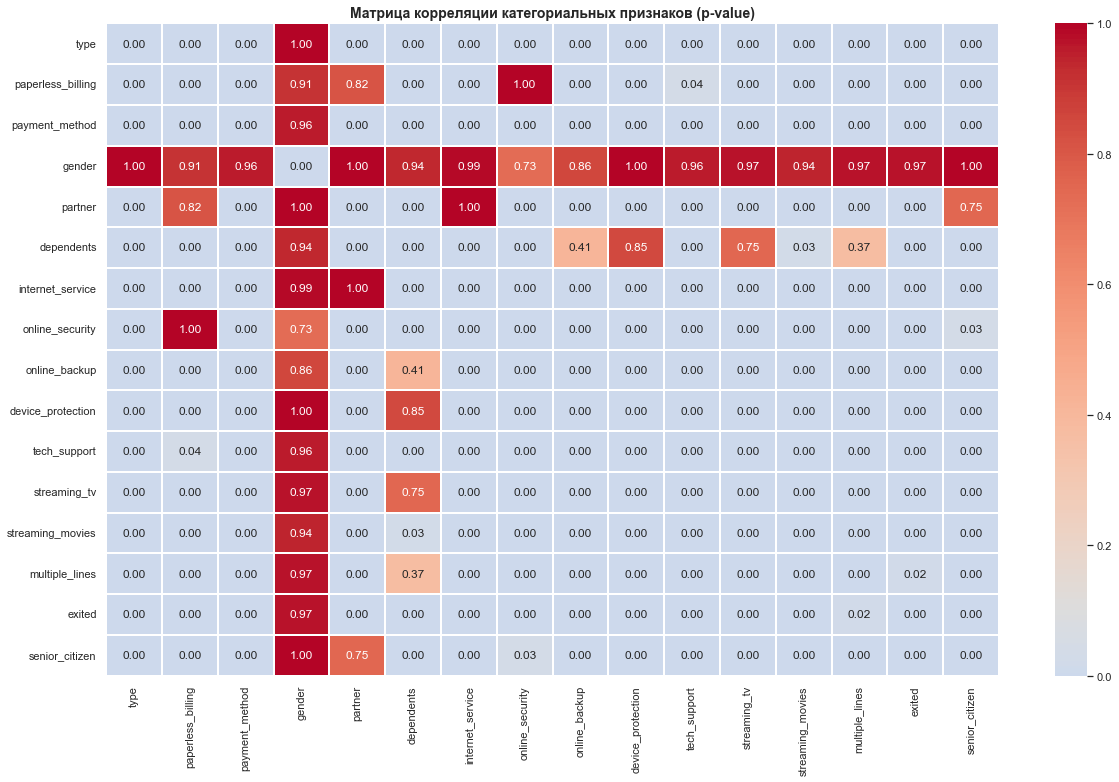

In [120]:
corr_matrix(result_p, title='Матрица корреляции категориальных признаков (p-value)', vmin=0, vmax=1, center=0.1)

По матрице корреляции видно, что большинство признаков взаимозависимы - p-value < 0,05. Независим от других только признак `gender` (пол).

Посмотрим на величину зависимости признаков. Для этого построим матрицу со значениями хи-квадрат. Чем выше значение хи-квадрат, тем сильнее зависимость переменных.

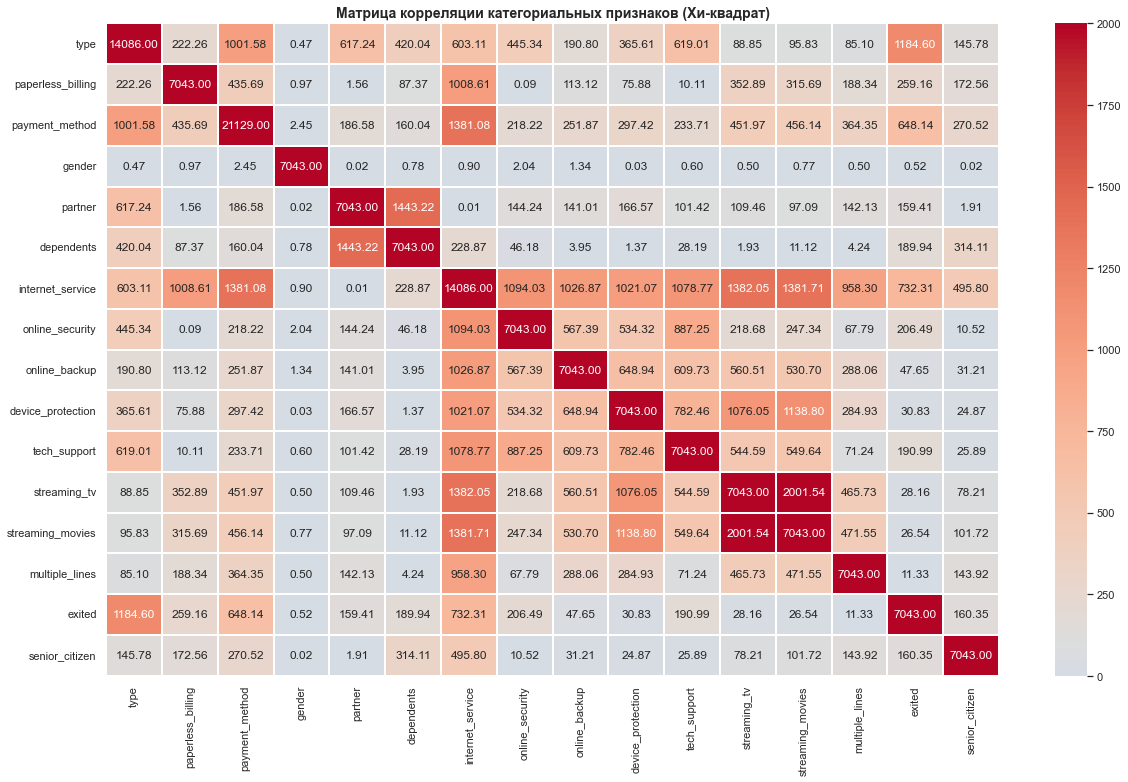

In [121]:
corr_matrix(result_chi, title='Матрица корреляции категориальных признаков (Хи-квадрат)', vmin=0, vmax=2000, center=100)

Из матрицы корреляции по величине хи-квадрат видно, что
- признак `internet_service` имеет довольно сильную корреляцию почти со всеми признаками.
- признак `dependents` коррелирует с `partner`.

Некоторые признаки можно удалить, чтобы уменьшить мультиколлинеарность. Те признаки, которые имеют наиболее сильное влияние на целевой признак (хи-квадрат > 200), удалять не будем.         

In [122]:
# удаление признаков
df_enc = df_enc.drop(['online_backup', 'device_protection', 'streaming_tv', 'streaming_movies',
                      'multiple_lines', 'partner', 'gender'], axis=1)

#### Мультиколлинеарность между парой количественных и категориальных признаков

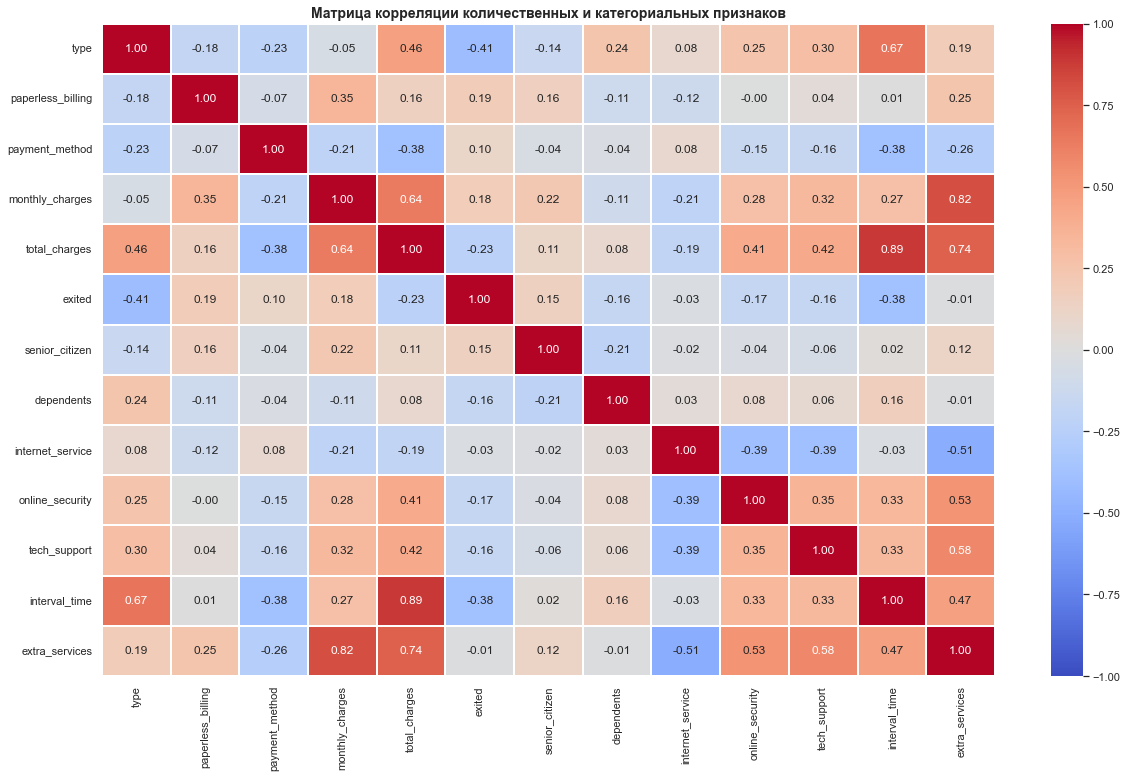

In [123]:
corr_matrix(df_enc.corr(method='spearman'),
            title='Матрица корреляции количественных и категориальных признаков',
            vmin=-1, vmax=1, center=0)

- Количественные признаки `total_charges`, `monthly_charges` довольно сильно коррелируют с другими признаками (коэффициент Спирмана доходит до 0,9). Данные признаки можно удалить.
- Количественный признак `extra_services` также довольно сильно коррелирует с другими признаками, но коэффициент Спирмана не превышает 0,7. Однако этот признак совсем не влияет на целевой (коэффициент Спирмана равен 0), поэтому его также можно удалить.

In [126]:
df_enc = df_enc.drop(['monthly_charges', 'total_charges', 'extra_services'], axis=1)

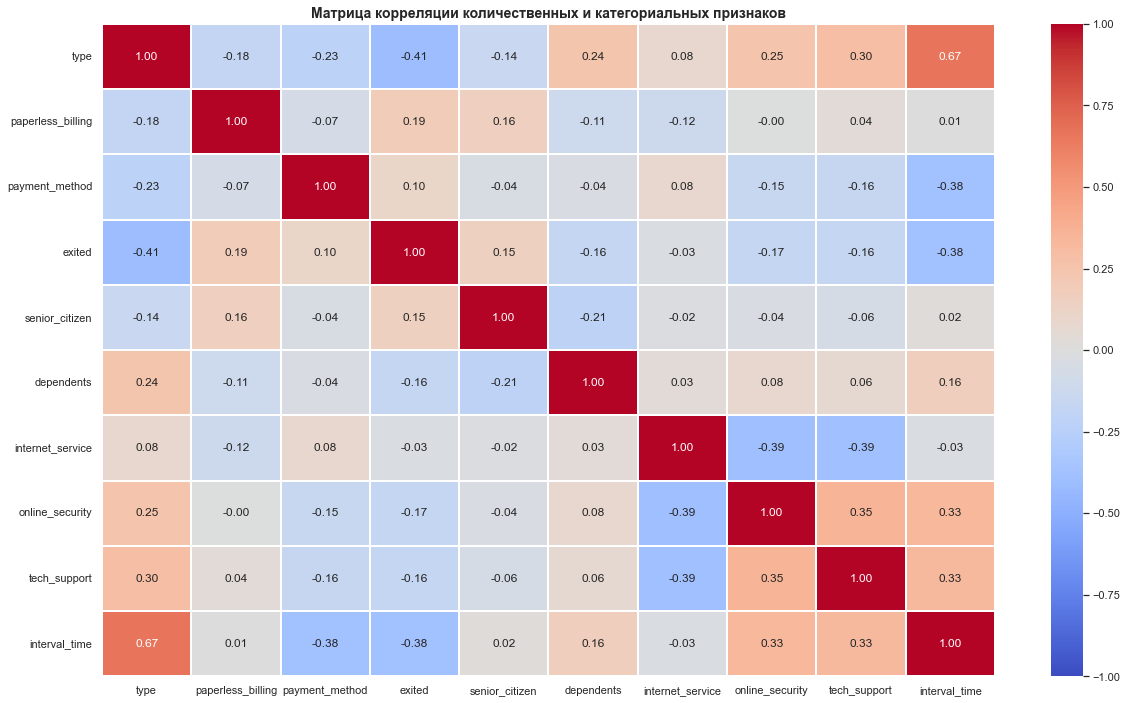

In [127]:
corr_matrix(df_enc.corr(method='spearman'),
            title='Матрица корреляции количественных и категориальных признаков',
            vmin=-1, vmax=1, center=0)

По матрице корреляции также видно, что наибольшее влияние на целевой признак оказывает количественный признак `interval_time` (как долго клиент обслуживается в компании) с коэффициентом Спирмана равным -0,4.

Исследуем его подробнее.

In [48]:
# функция для отрисовки гистограмм распределения по различным признакам с разделением по целевому признаку
def histogram(feature, title, xlabel, interval=1, rotation=0):
    """
        для interval_time:
        interval=365 - в год
        interval=30 - в месяц
    """
    plt.figure(figsize=(10,5));
    sns.set(style='darkgrid')

    sns.histplot(df.loc[df.exited == 0, feature]/interval, binwidth=1, stat="percent", label='клиенты')
    sns.histplot(df.loc[df.exited == 1, feature]/interval, binwidth=1, stat="percent", label='бывшие клиенты',
                 color='orange')
        
    plt.title(title, fontsize=13, weight='bold');
    plt.legend(fontsize=14, loc=1, facecolor='white');
    plt.xticks(rotation=rotation);
    plt.xlabel(xlabel, fontsize=14, );
    plt.ylabel('% клиентов', fontsize=14);

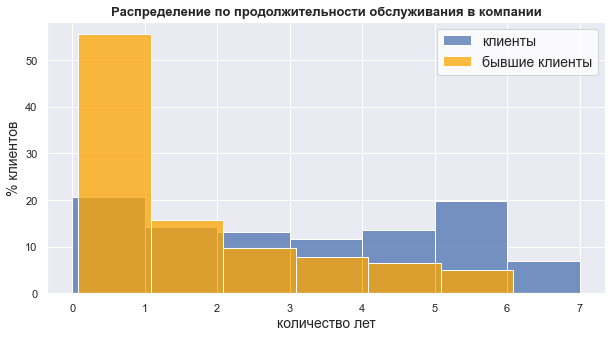

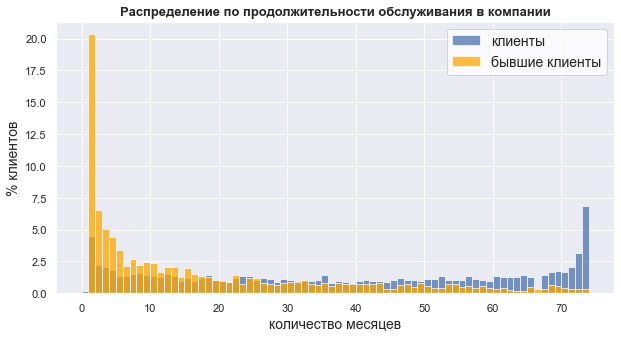

In [49]:
histogram(interval=365, feature='interval_time',
          title='Распределение по продолжительности обслуживания в компании',
          xlabel='количество лет')
histogram(interval=30, feature='interval_time',
          title='Распределение по продолжительности обслуживания в компании',
          xlabel='количество месяцев')

- Пик количества клиентов, покинувших компанию, приходится на первый месяц обслуживания.
- Чаще клиенты покидают компанию в первый год обслуживания.

Т.к. мы выяснили, что компанию покидают в основном новые клиенты, можно добавить признак `is_newbie` (новички) со значениями 1 - является клиентом менее полугода, 0 - является клиентом полгода и более.

In [50]:
df_enc['is_newbie'] = 0
df_enc.loc[df_enc.interval_time < 183, 'is_newbie'] = 1

In [51]:
df_enc.head(2)

,type,paperless_billing,payment_method,exited,senior_citizen,dependents,internet_service,online_security,tech_support,interval_time,is_newbie
customerID,,,,,,,,,,,
7590-VHVEG,0,1,2,0,0,0,0,0,0,31,1
5575-GNVDE,1,0,3,0,0,0,0,1,0,1036,0


### Анализ моделей

Для решения задачи классификации будем использовать следующие алгоритмы:
1. LogisticRegression,
2. DecisionTreeClassifier,
3. LGBMClassifier,
4. XGBClassifier,
5. CatBoostClassifier.

Для проверки моделей на правильность предсказаний нужно разбить данные на две части: **обучающую и тестовую**. Разобьем данные в соотношении 4:1.

Процентное соотношение от исходного датасета:
- обучающая выборка - 80%,
- тестовая выборка - 20%.

В качестве метрики качества применим **ROC_AUC**, которая равна площади под кривой ошибок. Чем выше значение ROC_AUC, тем лучше качество модели. Модель, дающая предсказания случайным образом, имеет значение ROC_AUC = 0,5.

In [52]:
# функция для разделения датасета на обучающую и тестовую выборки, на признаки (features) и целевой признак (target)
def split_df(data, target):
    # разделение в соотношении 4:1
    df_train, df_test = train_test_split(data, test_size=0.2, random_state=250722) 

    train_features = df_train.drop([target], axis=1)
    train_target = df_train[target]

    test_features = df_test.drop([target], axis=1)
    test_target = df_test[target]
    
    
    return train_features, train_target, test_features, test_target

In [53]:
# функция для определения гиперпараметров модели
def grid_search(model, params):
    grid_cv = GridSearchCV(estimator=model,
                           param_grid=params,
                           cv=5,
                           n_jobs=-1,
                           scoring='roc_auc')
    
    start_fit_time = time.time()
    grid_cv.fit(train_features, train_target)
    crossval_time = time.time() - start_fit_time
    
    print('Гиперпараметры: ', grid_cv.best_params_)
  
 # добавление результатов в таблицу 
    global a
    columns = ['model_name', 'model', 'time_sec', 'ROC_AUC', 'process']
    rows = [['', model, round(crossval_time, 1), round(grid_cv.best_score_, 3), 'кроссвалидация']]
    a = pd.DataFrame(data=rows, columns=columns)
    
    return grid_cv.best_params_

In [54]:
# таблица для накопления результатов
columns = ['model_name', 'model', 'time_sec', 'ROC_AUC', 'process']
result_tbl = pd.DataFrame(columns=columns)
result_tbl

,model_name,model,time_sec,ROC_AUC,process


Значения полей таблицы с результатами:
- **model_name** – название модели,
- **model** – конфигурация модели,
- **time_sec** – время выполнения процесса в секундах,
- **ROC_AUC** – метрика качества ROC_AUC,
- **process** - процесс (кроссвалидация/обучение/тестирование).

#### LogisticRegression

In [55]:
%%time
train_features, train_target, test_features, test_target = split_df(df_enc, target='exited')

Wall time: 5 ms


- solver = 'liblinear' - для небольших датасетов
- multi_class = 'ovr' - для бинарной задачи
- class_weight = 'balanced' - для автоматической корректировки баланса классов

In [56]:
best1 = grid_search(LogisticRegression(), params={'class_weight': [None, 'balanced'],
                                                  'C': [1.0, 0.1 ],
                                                  'solver': ['liblinear'],
                                                  'penalty': ['l1', 'l2'],
                                                  'multi_class': ['ovr'],
                                                  'random_state': [250722]
                                                 })
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

Гиперпараметры:  {'C': 1.0, 'class_weight': None, 'multi_class': 'ovr', 'penalty': 'l1', 'random_state': 250722, 'solver': 'liblinear'}


In [57]:
logreg = LogisticRegression(**best1)

#### DecisionTreeClassifier

- class_weight = 'balanced' - для автоматической корректировки баланса классов

In [58]:
best5 = grid_search(DecisionTreeClassifier(), params={'class_weight': [None, 'balanced'],
                                                      'max_depth': [2, 3, 5, 10, 20],
                                                      'min_samples_leaf': [5, 10, 20, 50, 100],
                                                      'criterion': ["gini", "entropy"],
                                                      'splitter': ['best', 'random'],
                                                      'random_state': [250722]
                                                     })
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

Гиперпараметры:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 20, 'random_state': 250722, 'splitter': 'best'}


In [59]:
dtree = DecisionTreeClassifier(**best5)

#### LGBMClassifier

- is_unbalance = True - для несбалансированных классов в бинарной классификации

In [60]:
best2 = grid_search(LGBMClassifier(), params={'is_unbalance': [True, False],
                                              'num_leaves': [31, 50, 100], 
                                              'learning_rate': [0.001, 0.01, 0.1],
                                              'max_bin': [255, 355, 555],
                                              'min_child_samples': [10, 100], 
                                              'min_child_weight': [0.00001, 0.001, 0.01],
                                              'random_state': [250722],
                                              'n_jobs': [-1]
                                            })
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

Гиперпараметры:  {'is_unbalance': True, 'learning_rate': 0.1, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 1e-05, 'n_jobs': -1, 'num_leaves': 50, 'random_state': 250722}


In [61]:
lgbm = LGBMClassifier(**best2)

#### XGBClassifier

- **scale_pos_weight** - контролирует баланс классов, вычисляется по формуле ***sum(negative instances) / sum(positive instances)***

In [62]:
best6 = grid_search(XGBClassifier(), params={'scale_pos_weight': [1, 2, 3, 4],
                                             'max_depth': [6, 12],
                                             'colsample_bytree': [0.3, 0.5, 0.8],
                                             'gamma': [0, 1, 3],
                                             'random_state': [250722],
                                             'n_jobs': [-1]
                                            })
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

Гиперпараметры:  {'colsample_bytree': 0.3, 'gamma': 1, 'max_depth': 12, 'n_jobs': -1, 'random_state': 250722, 'scale_pos_weight': 2}


In [63]:
xgb = XGBClassifier(**best6)

#### CatBoostClassifier

- auto_class_weights = 'Balanced' - для несбалансированных классов

In [64]:
best4 = grid_search(CatBoostClassifier(), params={'auto_class_weights': ['Balanced', 'None'],
                                                  'depth': [2, 6, 8],
                                                  'learning_rate': [0.1, 0.2, 0.4, 0.8], 
                                                  'verbose': [0],
                                                  'random_state': [250722]
                                                  })
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

Гиперпараметры:  {'auto_class_weights': 'None', 'depth': 2, 'learning_rate': 0.4, 'random_state': 250722, 'verbose': 0}


In [65]:
catboost = CatBoostClassifier(**best4)

In [66]:
result_tbl

,model_name,model,time_sec,ROC_AUC,process
0,,LogisticRegression(),3.1,0.811,кроссвалидация
0,,DecisionTreeClassifier(),3.2,0.850,кроссвалидация
0,,LGBMClassifier(),57.6,0.919,кроссвалидация
0,,"XGBClassifier(base_score=None, booster=None, c...",32.0,0.937,кроссвалидация
0,,<catboost.core.CatBoostClassifier object at 0x...,98.9,0.951,кроссвалидация


### Отбор признаков

Отберем признаки для модели **catboost** с лучшим значением метрики ROC_AUC. 

In [67]:
train_dataset = Pool(train_features, train_target)
catboost.fit(train_features, train_target)
feature_importance = catboost.get_feature_importance(train_dataset, prettified=True)
feature_importance

,Feature Id,Importances
0,interval_time,80.185711
1,type,6.820569
2,internet_service,6.021548
3,payment_method,2.529347
4,is_newbie,1.119509
5,paperless_billing,0.928418
6,tech_support,0.833887
7,dependents,0.809009
8,online_security,0.406379
9,senior_citizen,0.345623


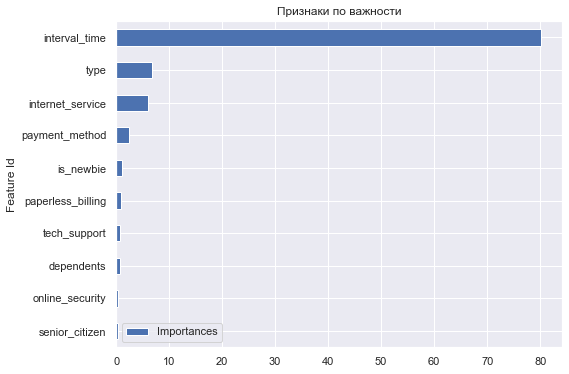

In [68]:
feature_importance.sort_values('Importances').set_index('Feature Id').plot(figsize=(8, 6), kind='barh',
                                                                           title='Признаки по важности');

Отберем признаки со значением **Importances > 1**.

In [69]:
train_features = train_features[list(feature_importance.loc[feature_importance['Importances'] > 1, 'Feature Id'])]
print(f'Отобрано', len(feature_importance.loc[feature_importance['Importances'] > 1, 'Feature Id']), 'признаков')
print(list(feature_importance.loc[feature_importance['Importances'] > 1, 'Feature Id']))

Отобрано 5 признаков
['interval_time', 'type', 'internet_service', 'payment_method', 'is_newbie']


Отбором признаков удалось установить, какие признаки влияют на целевой признак:
- продолжительность обслуживания в компании,
- тип оплаты,
- интернет-услуги,
- способ оплаты.

Рассчитаем контрольную метрику ROC_AUC на кроссвалидации после отбора признаков.

In [70]:
 np.mean(cross_val_score(catboost, train_features, train_target, cv=5, scoring='roc_auc'))

0.9510698975085029

### Анализ отобранных признаков

Проанализируем отобранные признаки: `interval_time`, `type`, `internet_service`, `payment_method`.

Признак `interval_time` был проанализирован в п.2.2. По графику распределения было установлено, что пик количества клиентов, покинувших компанию, приходится на первый месяц обслуживания, и то, что чаще клиенты покидают компанию в первый год обслуживания.

Посмотрим на остальные признаки.

In [71]:
def plot(feature, title, xlabel, rotation=0):
    plt.figure(figsize=(6,4));
    sns.set(style='darkgrid')

    sns.barplot(x=feature, y='exited', data=df, ci=None, color='#5DADE2')
  
    plt.title(title, fontsize=13, weight='bold');
    plt.xticks(rotation=rotation);
    plt.xlabel(xlabel, fontsize=14);
    plt.ylabel('доля бывших клиентов', fontsize=14);

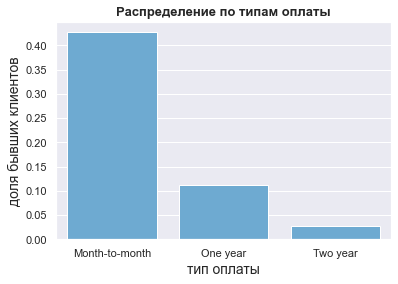

In [72]:
plot(feature='type', xlabel='тип оплаты', title='Распределение по типам оплаты')

Клиенты, покинувшие компанию, в основном использовали ежемесячную оплату.

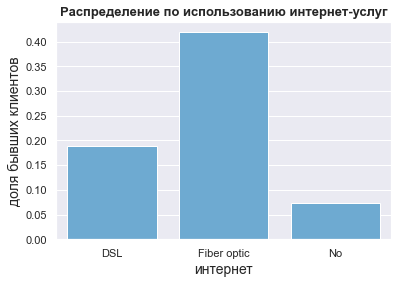

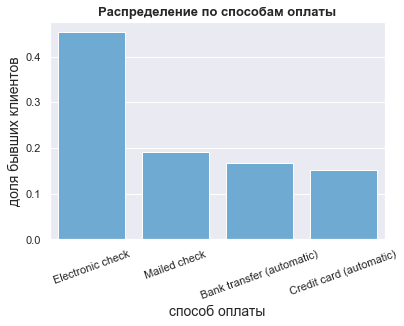

In [73]:
plot(feature='internet_service', xlabel='интернет', title='Распределение по использованию интернет-услуг')
plot(feature='payment_method', xlabel='способ оплаты', title='Распределение по способам оплаты', rotation=20)

Наблюдаются явные пики на интернет-услуге оптоволоконный кабель - Fiber optic (на первом графике) и на способе оплаты электронным чеком - Electronic check (на втором графике). Можно предположить, что клиенты недовольны данными услугами, поэтому уходят из компании.

**Вывод:**

Согласно проведенному исследованию можно составить предварительные предположения о том, какие клиенты в основном уходят из компании и почему. 
- уходят преимущественно новые клиенты, которые обслуживались в компании менее года, и при этом используют ежемесячную оплату,
- причинами ухода клиентов могли стать какие-либо проблемы, связанные с услугой интернета через оптоволоконный кабель, а также какие-либо проблемы со способом оплаты через электронный чек.

## Тестирование

Протестируем модель **catboost**.

In [74]:
# функция для тестирования модели
def test(model, name):
    
    start_fit_time = time.time()
    model.fit(train_features, train_target)
    fit_time = time.time() - start_fit_time
    
    probabilities_one_train = model.predict_proba(train_features)[:, 1]
    
    start_predict_time = time.time()
    predictions = model.predict(test_features)
    predict_time = time.time() - start_predict_time
    
    probabilities_one = model.predict_proba(test_features)[:, 1]
    
    global a
    columns = ['model_name', 'model', 'time_sec', 'ROC_AUC', 'process']
    rows = [[name, model, round(fit_time, 1),
             round(roc_auc_score(train_target, probabilities_one_train), 3),
             'обучение'],
            [name, model, round(predict_time, 1),
             round(roc_auc_score(test_target, probabilities_one), 3),
             'тестирование']]
    a = pd.DataFrame(data=rows, columns=columns)
    
    return predictions, probabilities_one

In [75]:
predictions, probabilities_one = test(catboost, name='catboost')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

In [80]:
result_tbl

,model_name,model,time_sec,ROC_AUC,process
0,,LogisticRegression(),3.1,0.811,кроссвалидация
0,,DecisionTreeClassifier(),3.2,0.850,кроссвалидация
0,,LGBMClassifier(),57.6,0.919,кроссвалидация
0,,"XGBClassifier(base_score=None, booster=None, c...",32.0,0.937,кроссвалидация
0,,<catboost.core.CatBoostClassifier object at 0x...,98.9,0.951,кроссвалидация
0,catboost,<catboost.core.CatBoostClassifier object at 0x...,1.4,0.965,обучение
1,catboost,<catboost.core.CatBoostClassifier object at 0x...,0.0,0.954,тестирование


Построим график ошибок ROC-кривую для выбранной модели. Для модели, которая всегда отвечает случайно, ROC-кривая выглядит как прямая, идущая из левого нижнего угла в верхний правый. Чем график выше, тем больше доля истинно положительных ответов (TPR) и лучше качество модели.

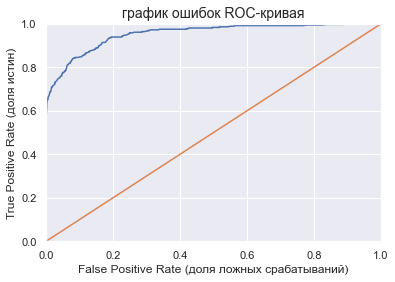

In [77]:
fpr, tpr, thresholds = roc_curve(test_target, probabilities_one)
    
plt.figure()
plt.plot(fpr, tpr, linestyle='solid')
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='solid')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (доля ложных срабатываний)')
plt.ylabel('True Positive Rate (доля истин)')
plt.title('график ошибок ROC-кривая', fontsize=14)

plt.show()

In [78]:
print('AUC_ROC:', round(roc_auc_score(test_target, probabilities_one), 3))
print('----------------')
print('Recall:', round(recall_score(test_target, predictions), 3))
print('Precision:', round(precision_score(test_target, predictions), 3))
print('F1-мера:', round(f1_score(test_target, predictions), 3))

AUC_ROC: 0.954
----------------
Recall: 0.71
Precision: 0.928
F1-мера: 0.804


### Интерпретация полученных результатов

**AUC_ROC: 0.95**
- Метрика AUC_ROC показывает, как сильно выбранная модель отличается от случайной, измеряется от 0 до 1. AUC_ROC случайной модели равна 0,5. Полученная метрика, равная 0,95, говорит, что выбранная модель дает более точные предсказания, чем случайная.

**Recall: 0.71**
- Recall (Полнота) показывает долю положительных ответов среди всех ответов.
- Интерпретируя полученный результат, получаем следующее: **если компанию покинет 100 клиентов, выбранная модель способна определить правильно 71 из них**.

**Precision: 0.93**
- Precision (Точность) определяет, как много отрицательных ответов нашла модель, пока искала положительные. 
- Интерпретируя полученный результат, получаем следующее: **если по прогнозу выбранной модели компанию покинет 100 клиентов, то 93 из них действительно ее покинут**.

## Общий вывод

В ходе проекта были исследованы исторические данные за период 2013-2020 гг. о клиентах оператора связи, их тарифах и договорах с целью создания модели прогнозирования оттока клиентов.

На этапе **предобработки данных** было сделано следующее:
- добавлен целевой признак,
- обработаны некорректные значения,
- изменены типы переменных там, где это было необходимо,
- таблицы с данными объединены в рабочий датасет, названия полей приведены к правильному стилю написания, заполнены пропуски, добавлена дополнительная информация, удалены поля с датами.
- категориальные признаки преобразованы в численные.

На этапе **исследования задачи** был выявлен дисбаланс классов в целевом признаке, соотношение клиентов бывших и настоящих составило 3:1. Анализ мультиколлинеарности признаков показал, что несколько признаков сильно коррелируют друг с другом. Мультиколлинеарность была устранена удалением некоторых признаков. 

Далее был проведен **анализ моделей**. С помощью GridSearchCV были подобраны гиперпараметры для нескольких моделей классификации: LogisticRegression, DecisionTreeClassifier, LGBMClassifier, XGBClassifier, CatBoostClassifier. Лучшие результаты контрольной метрики ROC_AUC показала модель градиентного бустинга **CatBoostClassifier**. Для данной модели был осуществлен отбор важных признаков, с помощью этой процедуры удалось установить перечень важных признаков. **Анализ отобранных признаков** помог составить предварительные предположения о том, какие клиенты в основном уходят из компании и почему. Оказалось, что уходят преимущественно новые клиенты, которые обслуживались в компании менее года, причинами ухода клиентов могли стать какие-либо проблемы, связанные с услугой интернета через оптоволоконный кабель, а также какие-либо проблемы со способом оплаты через электронный чек.

На этапе **тестирования** выбранной модели была получена итоговая метрика качества на тестовых данных **ROC_AUC = 0,95**. Также были рассчитаны другие метрики качества, которые дают важную информацию для формирования бизнес стратегии:
- **Recall = 0.71** означает, что выбранная модель способна определить правильно 71 клиента из 100, которые покинут компанию.
- **Precision = 0.93** означает, что 93 клиента из 100 предсказанных выбранной моделью действительно покинут компанию.